<center><h2>Binary Classifier of mdmnist Breast cancer images</h2></center>

In [63]:
# all the imports are listed here
import numpy as np 
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import math
import matplotlib as mpl

# NO SKLEARN HAS BEEN USED FOR MACHINE LEARNING, only the METRICS subpackage has been imported to compute AUC, F1 scores and so on.

Lets import the required data and noramalise it as required.
    

In [8]:
inputpath="breastmnist.npz"
train_images, val_images, test_images, train_labels, val_labels, test_labels = load_input(inputpath)


In [113]:
def load_input(inputpath):
    folder = np.load(inputpath)
    files = folder.files
    # print(files)
    # First we load the images and the labels
    un_train_images = folder['train_images.npy']
    un_val_images = folder['val_images.npy']
    un_test_images = folder['test_images.npy']
    train_labels = folder['train_labels.npy']
    val_labels = folder['val_labels.npy']
    test_labels = folder['test_labels.npy']
    # Then we normalize the images
    train_images = normalize_images(un_train_images)
    val_images = normalize_images(un_val_images)
    test_images = normalize_images(un_test_images)
    return train_images, val_images, test_images, train_labels, val_labels, test_labels


def normalize_images(images: np):
    new_images = np.zeros((images.shape[0], images.shape[1] * images.shape[2]))
    for i in range(images.shape[0]):
        new_images[i] = images[i].flatten()
    new_images = new_images.astype(np.float32)
    new_images /= 255.0
    return new_images

best_methods_AUC=dict()
best_methods_ACC=dict()

Lets get started with and try to solve this problem using various methods and test them using the scoring methods 

<center> <h3> K Nearest Neighbours</h3> </center>
Lets get right to it and write up the  core function to perform KNN

In [9]:
def knn_naive(X_train, Y_train, X_test, *, k=5, metric=2):
    # First we difeine a small function to return the k smallet elements of an array
    def k_smallest(arr, k):
        x = []
        min = np.inf
        pos_min = -1
        for i in range(k):
            for i in range(len(arr)):
                if arr[i] < min and i not in x:
                    min = arr[i]
                    pos_min = i
            if pos_min != -1:
                x.append(pos_min)
                min = np.inf
                pos_min = -1
        return x

    Y_test_predicted = np.zeros((X_test.shape[0], 1))
    if k == 0:
        return Y_test_predicted
    for i in range(X_test.shape[0]):
        distances = np.linalg.norm(np.abs(X_train - X_test[i, :]), ord=metric, axis=1)

        nearest = k_smallest(distances, k)
        topk_y = [i[0] for i in Y_train[nearest[:k]]]
        Y_test_predicted[i] = [np.argmax(np.bincount(topk_y))]

    return Y_test_predicted


Lets now run a small experiment, giving different values of k for KN

In [35]:
k_max=20
no_of_tests=4
x_graph = np.zeros((no_of_tests,k_max))
AUCscores = np.zeros(x_graph.shape)
ACCscores = np.zeros(x_graph.shape)
F1scores = np.zeros(x_graph.shape)

for j in range(no_of_tests):
    metric=j
    if j==0:
        metric =-math.inf
    elif j==no_of_tests-1:
        metric = math.inf
    for k in range(0, k_max):
        test_pred = knn_naive(train_images, train_labels, test_images, k=k, metric=metric)
        x_graph[j,k] = k
        F1scores[j,k] =metrics.f1_score(test_labels,test_pred)
        ACCscores[j,k] =metrics.accuracy_score(test_labels,test_pred)
        AUCscores[j,k] =metrics.roc_auc_score(test_labels,test_pred)


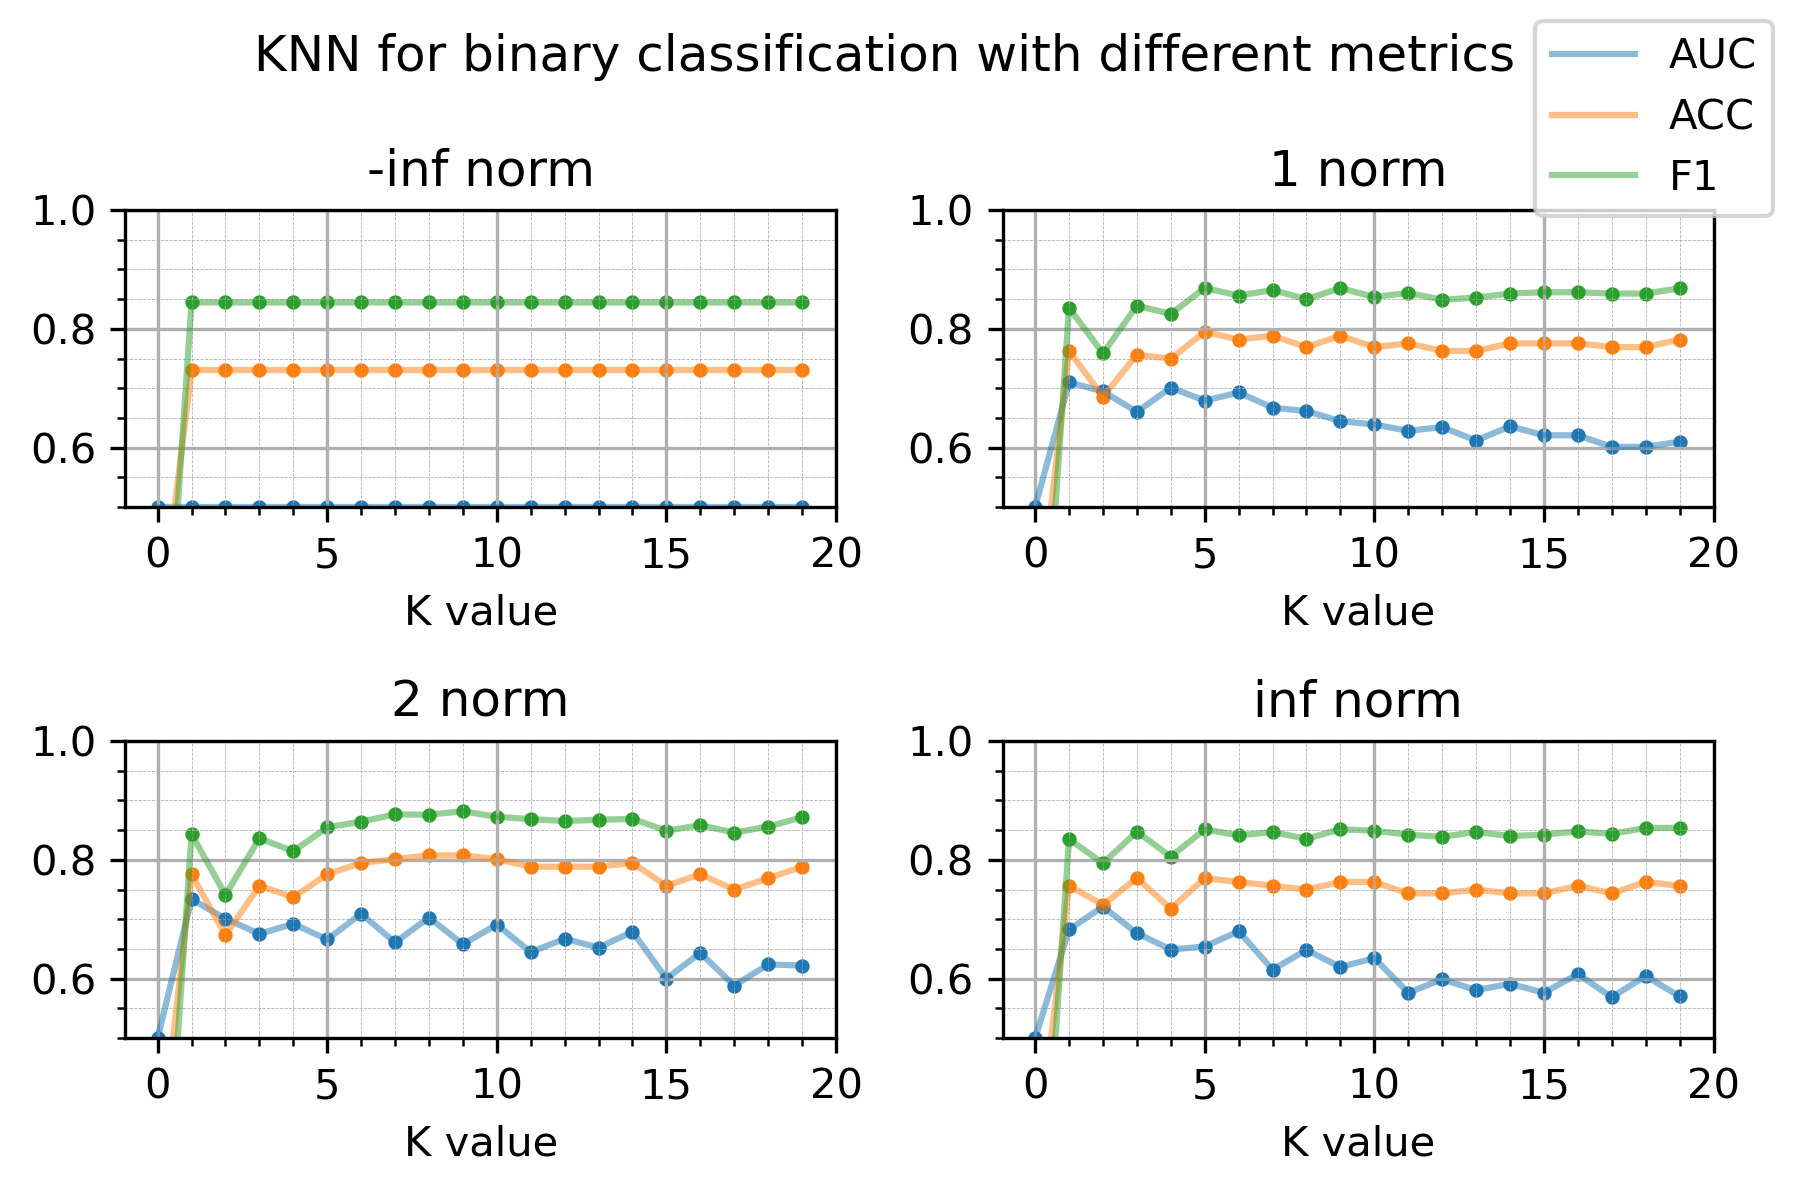

In [143]:
mpl.rcParams['figure.dpi'] = 300
for j in range(no_of_tests):
    metric=j
    if j==0:
        metric =-math.inf
    elif j==no_of_tests-1:
        metric = math.inf
    plt.subplot(2,2,j+1)
    plotter(x_graph[j],AUCscores[j],ACCscores[j],F1scores[j],str(metric)+" norm","K value",first=(j==0))

plt.suptitle("KNN for binary classification with different metrics")
plt.tight_layout()

#plt.figlegend(['AUC', 'ACC', 'F1'])

plt.show()

In [141]:
def plotter(x_graph, AUCscores, ACCscores, F1scores, title, xlabel,*,first=False):

    plt.plot(x_graph, AUCscores,alpha=0.5)
    plt.plot(x_graph, ACCscores,alpha=0.5 )
    plt.plot(x_graph, F1scores,alpha=0.5)
    plt.scatter(x_graph, AUCscores,s=6)
    plt.scatter(x_graph, ACCscores,s=6)
    plt.scatter(x_graph, F1scores,s=6)

    plt.xlabel(xlabel)
    plt.xticks(np.linspace(0, k_max, 5))
    plt.title(title)
    plt.ylim(0.5,1)
    plt.grid(True, which='major')
    plt.grid(True, which='minor',linestyle='--',linewidth=0.2)
    plt.minorticks_on()

    if first:
        plt.figlegend(['AUC', 'ACC', 'F1'])

In [116]:
count=0
print("best metrics according to AUC")
for i in np.argsort(AUCscores,axis=None,)[-3:]:
    best_metric,best_k =int( i//k_max), int(i%k_max    )
    best_score = AUCscores[int(best_metric)][int(best_k)]
    if best_metric==0:
        best_metric =-math.inf
    elif best_metric==no_of_tests-1:
        best_metric = math.inf
    print('\t'+str(3-count)+" best metric is ", best_metric,"(k=",best_k,")with a score of ",best_score)
    if 3-count==1:
        best_methods_AUC["KNN" + "(metric=" + str(best_metric) + ", k=" + str(best_k)]=best_score
    count+=1
print("best metrics according to ACC")
count=0
for i in np.argsort(ACCscores,axis=None,)[-3:]:
    best_metric,best_k =int( i//k_max), int(i%k_max    )
    best_score = ACCscores[int(best_metric)][int(best_k)]
    if best_metric==0:
        best_metric =-math.inf
    elif best_metric==no_of_tests-1:
        best_metric = math.inf
    print('\t'+str(3-count)+" best metric is ", best_metric,"(k=",best_k,")with a score of ",best_score)
    if 3-count==1:
        best_methods_AUC["KNN" + "(metric=" + str(best_metric) + ", k=" + str(best_k)]=best_score
    count+=1

best metrics according to AUC
	3 best metric is  1 (k= 1 )with a score of  0.7098997493734336
	2 best metric is  inf (k= 2 )with a score of  0.7211779448621555
	1 best metric is  2 (k= 1 )with a score of  0.7337092731829573
best metrics according to ACC
	3 best metric is  2 (k= 7 )with a score of  0.8012820512820513
	2 best metric is  2 (k= 9 )with a score of  0.8076923076923077
	1 best metric is  2 (k= 8 )with a score of  0.8076923076923077
